# Attention readout and visualisation

In [1]:
# this file uses the environment called attentionviz2

/home/ifender/miniconda3/envs/attentionviz2/bin/python


In [36]:

import os
import sys
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops
from rdkit import RDConfig
#plotting
from IPython.display import SVG
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from collections import namedtuple
import torch
from IPython.display import SVG
from IPython.display import Image, display
import io
import numpy as np
import re
import sys
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
#to import to get attention from model
import sys
sys.path.append('/home/ifender/SOS/SMILES_or_SELFIES/attention_visualized')
from attention_readout import gather_attention
from constants import PREDICTION_MODEL_PATH, TASK_MODEL_PATH, PARSING_REGEX, MOLNET_DIRECTORY
# PREDICTION_MODEL_PATH = Path("/data/jgut/SMILES_or_SELFIES/prediction_models") --> pretrained models
# TASK_MODEL_PATH = Path("/data2/jgut/SoS_models/") --> finetuned models

/home/ifender/miniconda3/envs/attentionviz2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/ifender/miniconda3/envs/attentionviz2/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
2024-07-09 13:35:45 | INFO | fairseq.tasks.text_to_speech | Pl

In [3]:
sys.path.insert(0,'/home/ifender/SOS/SMILES_or_SELFIES/atomtype_embedding_visualisation')
from atomtype_embedding_assignment import load_molnet_test_set, canonize_smiles, get_tokenized_SMILES, load_assignments_from_folder

## Functions

In [41]:
def clean_SMILES(SMILES_tok):
    """Removing structural tokens, hydrogens, and numbers from SMILES token input

    Args:
        SMILES_tok (_list_): List of SMILES_tokens for a given SMILES

    Returns:
        _list,list_: Processed SMILES_token list and list of positions in input tokens list that were kept
        (needed to distinguish which embeddings are relevant)
    """
    SMILES_tok_prep = list()
    struc_toks = r"()=:~1234567890#"
    posToKeep = list()
    pos = 0
    for i in range(len(SMILES_tok)):
        # when it's an H in the SMILES, ignore, cannot deal
        if SMILES_tok[i] != "H" and SMILES_tok[i] != "h" and not SMILES_tok[i].isdigit() and not SMILES_tok[i].isspace():
            if any(elem in struc_toks for elem in SMILES_tok[i]) == False:
                if SMILES_tok[i] != "-":
                    SMILES_tok_prep.append(SMILES_tok[i])
                    # keep pos where you keep SMILES token
                    posToKeep.append(pos)
        pos += 1
    assert(len(posToKeep) == (len(SMILES_tok_prep))
           ), f"Length of positions-to-keep-array ({len(posToKeep)}) and length of SMILES_tok_prep ({len(SMILES_tok_prep)}) are not the same"
    print("SMILES_tok: ", SMILES_tok)
    print("posToKeep: ", posToKeep)
    print("SMILES_tok_prep: ", SMILES_tok_prep)

    return SMILES_tok_prep, posToKeep


In [5]:

def cleanAndNormalizeAttention(attention_array,posToKeep,clean_smiles):
    # filter attention tensor according to posToKeep to only keep attention for non-hydrogen atoms
    filtered_attentions = attention_array[posToKeep]
    print(len(filtered_attentions))
    assert len(clean_smiles)==len(filtered_attentions), "Assert failed"
    # condense attention depending on method chosen
    mean_values = np.mean(filtered_attentions)
    min_val = np.min(filtered_attentions)
    max_val = np.max(filtered_attentions)
    normalized_means = (filtered_attentions - min_val) / (max_val - min_val)
    print("before normalisation: ",filtered_attentions)
    print("normalized means where all values fall between 0 and 1: ",normalized_means)
    return normalized_means



In [4]:
def norm_attention(attentions):
    min_val = np.min(attentions)
    max_val = np.max(attentions)
    normalized_means = (attentions - min_val) / (max_val - min_val)
    return normalized_means

In [6]:
def drawMoleculeWithAttention(orig_smiles,clean_smiles,norm_attentions):

    # Generate a color map from 0-1 scaled to attentions
    min_val = norm_attentions.min()
    max_val = norm_attentions.max()
    print(f"Minimum and maximum attention values: {min_val}, {max_val}")
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    scalar_map = plt.cm.ScalarMappable(norm=norm, cmap='viridis')

    mol = Chem.MolFromSmiles(orig_smiles)
    drawer = rdMolDraw2D.MolDraw2DCairo(300, 300)
    mol_with_style = rdMolDraw2D.PrepareMolForDrawing(mol, kekulize=False)

    # Set the drawing options
    opts = drawer.drawOptions()

    # Create a color map for the atoms
    atom_colors = {i: scalar_map.to_rgba(norm_attentions[i])[:-1] for i in range(mol.GetNumAtoms())}  # Remove alpha channel

    # Draw the molecule with colored atoms according to attention scores
    AllChem.Compute2DCoords(mol)
    d = rdMolDraw2D.MolDraw2DSVG(400, 400)
    rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=range(mol.GetNumAtoms()),
                                      highlightAtomColors=atom_colors)

    d.FinishDrawing()
    # get the SVG string
    svg = d.GetDrawingText()
    # fix the svg string and display it
    display(SVG(svg.replace('svg:','')))

    # Colorbar
    plt.figure(figsize=(4.5, 0.5))
    img = np.array([[min_val, max_val]])
    plt.imshow(img, cmap='viridis')
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.8, 0.6])
    colba = plt.colorbar(cax=cax, orientation="horizontal")
    colba.set_label('Attention Score')
    plt.savefig("test.png")
    plt.show()

In [7]:
def colorAtomsByAttention(smiles):
    #tokenize, only atomwise supported
    #smiles_tok = re.findall(r'Cl|.', smiles)
    smiles_tok = [elem for elem in re.split(PARSING_REGEX,smiles) if elem]
    clean_smiles,posToKeep = clean_SMILES(smiles_tok)
    # get attention from model, only BART for now
    attention = gather_attention(smiles,
                 smiles_atom_path=PREDICTION_MODEL_PATH/"smiles_atom_isomers_bart"/"checkpoint_last.pt",
                 smiles_sentencepiece_path=PREDICTION_MODEL_PATH/"smiles_trained_isomers_bart"/"checkpoint_last.pt",
                 selfies_atom_path=PREDICTION_MODEL_PATH/"selfies_atom_isomers_bart"/"checkpoint_last.pt",
                 selfies_sentencepiece_path=PREDICTION_MODEL_PATH/"selfies_trained_isomers_bart"/"checkpoint_last.pt")
    # remove attention on hydrogens, numbers, structural tokens and minmax normalize attention to values between 0 and 1
    norm_attention = cleanAndNormalizeAttention(attention,posToKeep,clean_smiles)
    # draw molecule with colored atoms according to attention scores
    drawMoleculeWithAttention(smiles,clean_smiles,norm_attention)

In [5]:
def gather_attention_for_manySMILES(task_smiles):
    # PREDICTION_MODEL_PATH = Path("/data/jgut/SMILES_or_SELFIES/prediction_models") --> pretrained models
    TASK_MODEL_PATH = Path("/data2/jgut/SoS_models/") #--> finetuned models
    atts = {}
    for smiles in task_smiles:
        #print(smiles)
        atts[smiles] = {}
        attention_bart_pretrained = gather_attention(smiles,
                 smiles_atom_path=PREDICTION_MODEL_PATH/"smiles_atom_isomers_bart"/"checkpoint_last.pt",
                 smiles_sentencepiece_path=PREDICTION_MODEL_PATH/"smiles_trained_isomers_bart"/"checkpoint_last.pt",
                 selfies_atom_path=PREDICTION_MODEL_PATH/"selfies_atom_isomers_bart"/"checkpoint_last.pt",
                 selfies_sentencepiece_path=PREDICTION_MODEL_PATH/"selfies_trained_isomers_bart"/"checkpoint_last.pt")
        attention_bart_finetuned = gather_attention(smiles,
                 smiles_atom_path=TASK_MODEL_PATH/"delaney"/"smiles_atom_isomers_bart"/"1e-05_0.2_seed_0"/"checkpoint_best.pt",
                 smiles_sentencepiece_path=TASK_MODEL_PATH/"smiles_trained_isomers_bart"/"checkpoint_last.pt",
                 selfies_atom_path=PREDICTION_MODEL_PATH/"selfies_atom_isomers_bart"/"checkpoint_last.pt",
                 selfies_sentencepiece_path=PREDICTION_MODEL_PATH/"selfies_trained_isomers_bart"/"checkpoint_last.pt")
        atts[smiles]['attention_bart_pretrained']=attention_bart_pretrained
        atts[smiles]['attention_bart_finetuned']=attention_bart_finetuned
        #print("atention bart pretrained: ",attention_bart_pretrained)
        #print("attention bart finetuned: ",attention_bart_finetuned)
    return atts

In [19]:
def add_clean_att_and_normatt_into_dikt(dikt,smiles_to_att_dict,smiles_dict):
    #dict_keys(['posToKeep', 'smi_clean', 'atom_types', 'max_penalty'])
    atomtypes_to_two_attentions={}
    for key, val in dikt.items():
        atomtypes_to_two_attentions[key]=[]
        dikt[key]['attention_bart_pretrained']={}
        dikt[key]['attention_bart_finetuned']={}
        if dikt[key]['posToKeep']!=None:
            print(key)
            posToKeeplist = dikt[key]['posToKeep']
            assert key in smiles_to_att_dict, "key not in smiles_to_att_dict"
            assert len(smiles_dict[key])==len(smiles_to_att_dict[key]['attention_bart_pretrained']), f"length of tokenized smiles in smiles dict ({len(smiles_dict[key])}) and smiles_to_att_dict pretrained ({len(smiles_to_att_dict[key]['attention_bart_pretrained'])}) not equal"
            assert len(smiles_dict[key])==len(smiles_to_att_dict[key]['attention_bart_finetuned']), f"length of tokenized smiles in smiles dict ({len(smiles_dict[key])}) and smiles_to_att_dict finetuned ({len(smiles_to_att_dict[key]['attention_bart_finetuned'])}) not equal"
            
            # for pretrained
            it='attention_bart_pretrained'
            clean_atts_pre = [item for index, item in enumerate(smiles_to_att_dict[key][it]) if index in posToKeeplist]
            print(dikt[key]['atom_types'])
            print("clean atts: ",clean_atts_pre)
            dikt[key][it]['raw_attention']=smiles_to_att_dict[key][it]
            dikt[key][it]['clean_attention']=clean_atts_pre
            dikt[key][it]['atomtype_to_clean_attention']=[(atype, clean_att) for atype, clean_att in zip(dikt[key]['atom_types'],clean_atts_pre)]
            norm_atts_pre = norm_attention(clean_atts_pre)
            print("norm ats pre: ",norm_atts_pre)
            dikt[key][it]['atomtype_to_norm_attention']=[(atype, norm_att) for atype, norm_att in zip(dikt[key]['atom_types'],norm_atts_pre)]
           
            # for finetuned
            it='attention_bart_finetuned'
            clean_atts_fine = [item for index, item in enumerate(smiles_to_att_dict[key][it]) if index in posToKeeplist]
            print(dikt[key]['atom_types'])
            print("clean atts: ",clean_atts_fine)
            dikt[key][it]['raw_attention']=smiles_to_att_dict[key][it]
            dikt[key][it]['clean_attention']=clean_atts_fine
            dikt[key][it]['atomtype_to_clean_attention']=[(atype, clean_att) for atype, clean_att in zip(dikt[key]['atom_types'],clean_atts_fine)]
            norm_atts_fine = norm_attention(clean_atts_fine)
            print("norm ats: ",norm_atts_fine)
            dikt[key][it]['atomtype_to_norm_attention']=[(atype, norm_att) for atype, norm_att in zip(dikt[key]['atom_types'],norm_atts_fine)]
        
            atomtype_to_clean_combined_atts = [(atype, [pre, fine]) for atype, pre, fine in zip(dikt[key]['atom_types'], clean_atts_pre, clean_atts_fine)]
            dikt[key]['atomtype_to_clean_atts_pre_fine'] = atomtype_to_clean_combined_atts
            atomtype_to_clean_normed_combined_atts = [(atype, [pre, fine]) for atype, pre, fine in zip(dikt[key]['atom_types'], norm_atts_pre, norm_atts_fine)]
            dikt[key]['atomtype_to_clean_normed_atts_pre_fine'] = atomtype_to_clean_normed_combined_atts
        else:
                for it in ['attention_bart_pretrained','attention_bart_finetuned']:
                    dikt[key][it]['raw_attention']=None
                    dikt[key][it]['clean_attention']=None
                    dikt[key][it]['atomtype_to_clean_attention']=None
                    dikt[key][it]['atomtype_to_norm_attention']=None
                    dikt[key]['atomtype_to_clean_atts_pre_fine']=None
                    dikt[key]['atomtype_to_clean_normed_atts_pre_fine']=None


In [56]:
def plotter_atomtypes_vs_attention_pretrained_finetuned(atomtypes,x_values,y_values,elementname):
    unique_atom_types = list(set(atomtypes))
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_atom_types)))
    color_map = dict(zip(unique_atom_types, colors))

    fig,ax = plt.subplots()
    # Plot each point, specifying its color based on atom type
    for atom_type, x, y in zip(atomtypes, x_values, y_values):
        plt.scatter(x, y, color=color_map[atom_type], label=atom_type)

    # Optional: Create a legend for the colors. This might create a large legend if there are many atom types.
    # To avoid repeating labels in the legend, we handle them separately
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Removing duplicates
    ax.legend(by_label.values(), by_label.keys(),loc='center right', bbox_to_anchor=(1.5, 0.5),fontsize=17)

    ax.set_xlabel('Attention Pretraining',fontsize=17)
    ax.set_ylabel('Attention Finetuning',fontsize=17)
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.tick_params(length=8, width=3, labelsize=15)
    ax.set_title(f'Attention on Atom Types of {elementname}',fontsize=21)
    fig.show()

## Main

### Get attention for every molecule of Delaney dataset

In [7]:
# get SMILES from task
task = "delaney"
#task = "bace_classification"
assert task in list(
    MOLNET_DIRECTORY.keys()
), f"{task} not in MOLNET tasks."

# get SMILES from task
task_SMILES, task_labels = load_molnet_test_set(task)
print(f"SMILES: {task_SMILES} \n len task_SMILES delaney: {len(task_SMILES)}")

# make sure all task SMILES are the canonical SMILES
task_SMILES = [canonize_smiles(smiles) for smiles in task_SMILES]

# get tokenized version of dataset, SMILES mapped to tokenised version
smiles_dict = get_tokenized_SMILES(task_SMILES)
    
# get atom assignments from folder that contains antechamber atom assignments and parmchk files
dikt, totalfails, failedSmiPos, posToKeep_list = load_assignments_from_folder("./../atomtype_embedding_visualisation/delaney_mols_bccc0_gaff2_assigned", smiles_dict, task_SMILES)

2024-07-09 13:36:15 | INFO | deepchem.data.datasets | Loading dataset from disk.
2024-07-09 13:36:15 | INFO | deepchem.data.datasets | Loading dataset from disk.
2024-07-09 13:36:15 | INFO | deepchem.data.datasets | Loading dataset from disk.


SMILES: ['c1cc2ccc3cccc4ccc(c1)c2c34' 'Cc1cc(=O)[nH]c(=S)[nH]1'
 'O=C1OC(c2ccc(O)cc2)(c2ccc(O)cc2)c2ccccc21'
 'c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34' 'C1=Cc2cccc3cccc1c23' 'CC1CO1'
 'CCN1c2ccccc2N(C)C(=S)c2cccnc21' 'CC12CCC3c4ccc(O)cc4CCC3C1CCC2=O'
 'Cn1cc(-c2ccccc2)c(=O)c(-c2cccc(C(F)(F)F)c2)c1'
 'O=CNC(N1C=CN(C(NC=O)C(Cl)(Cl)Cl)C=C1)C(Cl)(Cl)Cl'
 'COc1c2occc2cc2ccc(=O)oc12' 'CN1C(C(=O)Nc2ccccn2)=C(O)c2ccccc2S1(=O)=O'
 'Cc1cc2nc3c(=O)[nH]c(=O)nc-3n(CC(O)C(O)C(O)CO)c2cc1C'
 'c1ccc(-c2ccc(-c3ccccc3)cc2)cc1'
 'CC12CC(=O)C3C(CCC4=CC(=O)CCC43C)C1CCC2=O' 'c1ccc2c(c1)sc1ccccc12'
 'C#CC1(O)CCC2C3CCC4=Cc5oncc5CC4(C)C3CCC21C' 'O=C(c1ccccc1)C(O)c1ccccc1'
 'OCc1ccccc1OC1OC(CO)C(O)C(O)C1O' 'CC1=C2C3OC(=O)C(C)C3CCC2(C)C=CC1=O'
 'O=Cc1ccc2c(c1)OCO2' 'CC1CCCCC1NC(=O)Nc1ccccc1'
 'CC(=O)N(c1onc(C)c1C)S(=O)c1ccc(N)cc1' 'CC(C)CNC(=O)N1CCNC1=O'
 'CNC(=O)Oc1ccccc1C1OCCO1' 'CC1=C(C(=O)Nc2ccccc2)CCCO1'
 'Cn1c(=O)on(-c2ccc(Cl)c(Cl)c2)c1=O' 'c1cc2c3c(cccc3c1)CC2'
 'c1ccc2cc3c(cc2c1)-c1cccc2cccc-3c12' 'Nc1cc(N2CCCCC

100%|██████████| 113/113 [00:00<00:00, 1454.53it/s]


SMILES tokens: ['c', '1', 'c', 'c', '2', 'c', 'c', 'c', '3', 'c', 'c', 'c', 'c', '4', 'c', 'c', 'c', '(', 'c', '1', ')', 'c', '2', 'c', '3', '4']
['mol_0.mol2', 'mol_1.mol2', 'mol_2.mol2', 'mol_3.mol2', 'mol_4.mol2', 'mol_5.mol2', 'mol_6.mol2', 'mol_7.mol2', 'mol_8.mol2', 'mol_9.mol2', 'mol_10.mol2', 'mol_11.mol2', 'mol_12.mol2', 'mol_13.mol2', 'mol_14.mol2', 'mol_15.mol2', 'mol_16.mol2', 'mol_17.mol2', 'mol_18.mol2', 'mol_19.mol2', 'mol_20.mol2', 'mol_21.mol2', 'mol_22.mol2', 'mol_23.mol2', 'mol_24.mol2', 'mol_25.mol2', 'mol_26.mol2', 'mol_27.mol2', 'mol_28.mol2', 'mol_29.mol2', 'mol_30.mol2', 'mol_31.mol2', 'mol_32.mol2', 'mol_33.mol2', 'mol_34.mol2', 'mol_35.mol2', 'mol_36.mol2', 'mol_37.mol2', 'mol_38.mol2', 'mol_39.mol2', 'mol_40.mol2', 'mol_41.mol2', 'mol_42.mol2', 'mol_43.mol2', 'mol_44.mol2', 'mol_45.mol2', 'mol_46.mol2', 'mol_47.mol2', 'mol_48.mol2', 'mol_49.mol2', 'mol_50.mol2', 'mol_51.mol2', 'mol_52.mol2', 'mol_53.mol2', 'mol_54.mol2', 'mol_55.mol2', 'mol_56.mol2', 'mol_57.

2024-07-09 13:36:15 | INFO | root | File creation from SMILES to pdb by obabel failed 0 times out of 113
2024-07-09 13:36:15 | INFO | root | Atom assignment by antechamber failed 20 times out of 113
2024-07-09 13:36:15 | INFO | root | Length of failed SMILES positions (20) of these antechamber failed SMILES: (20), parmcheck failed SMILES: (0).
2024-07-09 13:36:15 | INFO | root | Antechamber failed to assign atom types to the following (20) SMILES: ['Cc1cc(=O)[nH]c(=S)[nH]1', 'Cn1cc(-c2ccccc2)c(=O)c(-c2cccc(C(F)(F)F)c2)c1', 'COc1c2occc2cc2ccc(=O)oc12', 'Cc1cc2nc3c(=O)[nH]c(=O)nc-3n(CC(O)C(O)C(O)CO)c2cc1C', 'C#CC1(O)CCC2C3CCC4=Cc5oncc5CC4(C)C3CCC21C', 'CC(=O)N(c1onc(C)c1C)S(=O)c1ccc(N)cc1', 'Cn1c(=O)on(-c2ccc(Cl)c(Cl)c2)c1=O', 'Nc1cc(N2CCCCC2)nc(N)[n+]1[O-]', 'O=c1oc2ccccc2c(O)c1C1CCCc2ccccc21', 'c1ccc2ocnc2c1', 'O=c1c(O)c(-c2ccc(O)cc2O)oc2cc(O)cc(O)c12', 'c1ccc2c(c1)oc1ccccc12', 'O=c1[nH]cnc2nc[nH]c12', 'Cc1ccccc1-n1c(C)nc2ccccc2c1=O', 'CSc1nnc(C(C)(C)C)c(=O)n1N', 'O=C1CN(N=Cc2ccc([N+](

['cc', 'cc', 'cd', 'ss', 'cd']
(5 == 5)
110
SMILES_tok:  ['c', '1', 'c', 'c', 'c', '2', 'c', '(', 'c', '1', ')', 'c', 'c', 'c', '1', 'c', '2', 'c', 'c', 'c', '2', 'c', '3', 'c', 'c', 'c', 'c', 'c', '3', 'c', 'c', 'c', '2', '1']
posToKeep:  [0, 2, 3, 4, 6, 8, 11, 12, 13, 15, 17, 18, 19, 21, 23, 24, 25, 26, 27, 29, 30, 31]
SMILES_tok_prep:  ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']
smi: c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21, smiles_tokens ['c', '1', 'c', 'c', 'c', '2', 'c', '(', 'c', '1', ')', 'c', 'c', 'c', '1', 'c', '2', 'c', 'c', 'c', '2', 'c', '3', 'c', 'c', 'c', 'c', 'c', '3', 'c', 'c', 'c', '2', '1'], smi_clean ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']
num 110 extracted from mol2 mol_110.mol2
['ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca']
(22 == 22)
111
SMILES_tok:

In [8]:
smiles_to_att_dict = gather_attention_for_manySMILES(task_SMILES)

2024-07-09 13:36:23 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-09 13:36:23 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-09 13:36:24 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
/home/ifender/miniconda3/envs/attentionviz2/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
2024-07-09 13:36:25 | INFO | fairseq.models.bart.model | Regis

In [9]:
print("smiles_to_att_dict: ",smiles_to_att_dict['c1cc2ccc3cccc4ccc(c1)c2c34'])

smiles_to_att_dict:  {'attention_bart_pretrained': array([0.01732512, 0.05493717, 0.0463205 , 0.07805961, 0.11321026,
       0.05226177, 0.04052735, 0.04309419, 0.03298041, 0.02633271,
       0.02514527, 0.02384851, 0.02334529, 0.02591144, 0.02311009,
       0.06307255, 0.03149052, 0.0381921 , 0.0223051 , 0.04946436,
       0.02806857, 0.02169168, 0.04377414, 0.0207397 , 0.02407987,
       0.03071172]), 'attention_bart_finetuned': array([0.01830916, 0.06838366, 0.09466814, 0.09047666, 0.14320661,
       0.04513778, 0.03317874, 0.04606932, 0.0371146 , 0.02580001,
       0.0216296 , 0.01970683, 0.01921946, 0.02439765, 0.02065018,
       0.02012819, 0.01956015, 0.03727687, 0.01949305, 0.03857898,
       0.02548745, 0.01987929, 0.03635971, 0.01986402, 0.02589271,
       0.0295312 ])}


In [20]:
add_clean_att_and_normatt_into_dikt(dikt,smiles_to_att_dict,smiles_dict)


c1cc2ccc3cccc4ccc(c1)c2c34
['ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca']
clean atts:  [0.01732512377202511, 0.04632049798965454, 0.0780596062541008, 0.05226176977157593, 0.0405273474752903, 0.04309419170022011, 0.026332708075642586, 0.0251452699303627, 0.023848513141274452, 0.02334529347717762, 0.02311009354889393, 0.0630725547671318, 0.031490519642829895, 0.02230510301887989, 0.021691681817173958, 0.02073969505727291]
norm ats pre:  [0.         0.47741206 1.         0.57523576 0.38202719 0.42429057
 0.14831088 0.12875958 0.10740833 0.09912276 0.09525017 0.75323653
 0.23323482 0.08199591 0.07189586 0.0562213 ]
['ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca']
clean atts:  [0.018309155479073524, 0.09466814249753952, 0.09047666192054749, 0.04513777792453766, 0.03317874297499657, 0.046069324016571045, 0.025800010189414024, 0.02162959985435009, 0.019706830382347107, 0.019219456240534782, 0.020

In [54]:
# Get all atom types and their corresponding x and y values
atom_types = []
x_values = []
y_values = []
o_atom_types = []
o_x_values = []
o_y_values = []

for key, val in dikt.items():
    if 'atomtype_to_clean_atts_pre_fine' in val:
        atomtype_to_clean_normed_atts_pre_fine = val['atomtype_to_clean_atts_pre_fine']
        if atomtype_to_clean_normed_atts_pre_fine is not None:
            for atomtype, values in atomtype_to_clean_normed_atts_pre_fine:
                if atomtype=='c3' or atomtype=='c2' or atomtype=='c':
                    atom_types.append(atomtype)
                    x_values.append(values[0])
                    y_values.append(values[1])
                if atomtype.startswith('o') and atomtype!="op":
                    o_atom_types.append(atomtype)
                    o_x_values.append(values[0])
                    o_y_values.append(values[1])

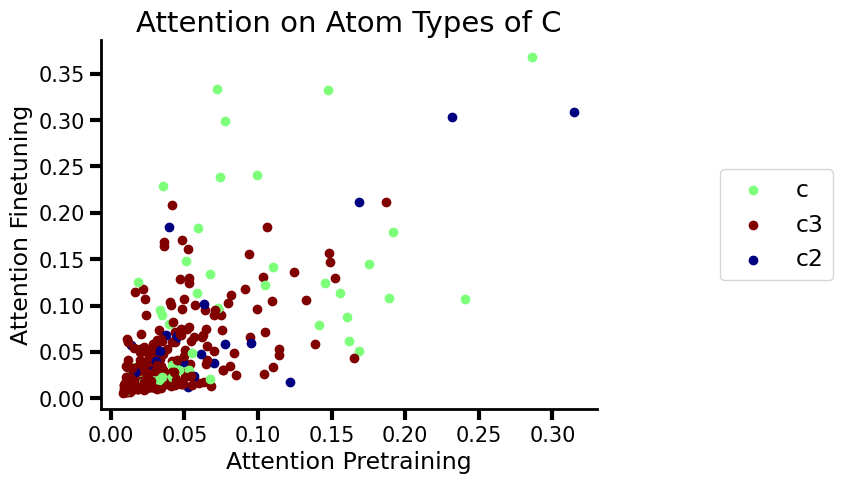

In [57]:
elementname="C"
plotter_atomtypes_vs_attention_pretrained_finetuned(atom_types,x_values,y_values,elementname)

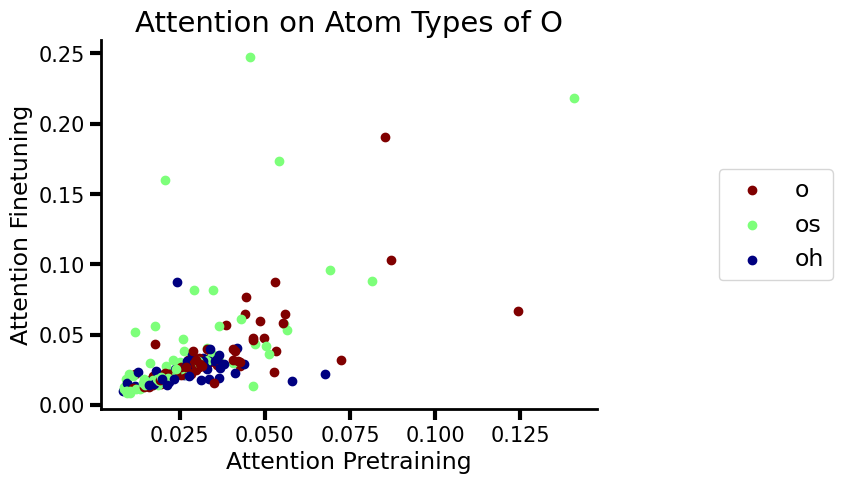

In [58]:
elementname="O"
plotter_atomtypes_vs_attention_pretrained_finetuned(o_atom_types,o_x_values,o_y_values,elementname)